# Web Mining and Applied NLP (44-620)

## Requests, JSON, and NLP

### Derek Fintel

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

Make sure you have [installed spaCy and its pipeline](https://spacy.io/usage#quickstart) and [spaCyTextBlob](https://spacy.io/universe/project/spacy-textblob)

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

This assignment requires that you write additional files (either JSON or pickle files); make sure to submit those files in your repository as well.

#### Initial version check

In [34]:
import spacy
import spacytextblob

print(spacy.__version__)
print(spacytextblob.__version__)

3.8.7
5.0.0


1. The following code accesses the [lyrics.ovh](https://lyricsovh.docs.apiary.io/#reference/0/lyrics-of-a-song/search) public api, searches for the lyrics of a song, and stores it in a dictionary object.  Write the resulting json to a file (either a JSON file or a pickle file; you choose). You will read in the contents of this file for future questions so we do not need to frequently access the API.

In [35]:
import requests
import json

result = json.loads(requests.get('https://api.lyrics.ovh/v1/They Might Be Giants/Birdhouse in your soul').text)

with open('lyrics.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

2. Read in the contents of your file.  Print the lyrics of the song (not the entire dictionary!) and use spaCyTextBlob to perform sentiment analysis on the lyrics.  Print the polarity score of the sentiment analysis.  Given that the range of the polarity score is `[-1.0,1.0]` which corresponds to how positive or negative the text in question is, do you think the lyrics have a more positive or negative connotation?  Answer this question in a comment in your code cell.

In [ ]:
import json
import spacy
from spacy.tokens import Doc
from spacytextblob.spacytextblob import SpacyTextBlob

# Load model
nlp = spacy.load("en_core_web_sm")

# Add component via factory string
if "spacytextblob" not in nlp.pipe_names:
    nlp.add_pipe("spacytextblob", last=True)

# Print pipeline components
print("Pipeline components:", nlp.pipe_names)

# Manually register the extensions 
if not Doc.has_extension("polarity"):
    Doc.set_extension("polarity", getter=lambda doc: doc._.blob.polarity)
if not Doc.has_extension("subjectivity"):
    Doc.set_extension("subjectivity", getter=lambda doc: doc._.blob.subjectivity)

# Load lyrics from file
with open("lyrics.json", "r", encoding="utf-8") as f:
    data = json.load(f)
lyrics = data["lyrics"]

# Preview
print("\n_lyrics preview:_\n", f"*{lyrics[:100]}...*")  

# Run pipeline
doc = nlp(lyrics)

# Access registered attributes and round results
polarity = round(doc._.polarity, 2)
subjectivity = round(doc._.subjectivity, 2)

# Print results
print("\nPolarity:", polarity)
print("Subjectivity:", subjectivity)


Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'spacytextblob']

_lyrics preview:_
 *I'm your only friend 
I'm not your only friend 
But I'm a little glowing friend 
But really I'm not ...*

Polarity: 0.05
Subjectivity: 0.55


3. Write a function that takes an artist, song, and filename, accesses the lyrics.ovh api to get the song lyrics, and writes the results to the specified filename.  Test this function by getting the lyrics to any four songs of your choice and storing them in different files.

In [40]:
import requests
import json
import os

def save_lyrics_to_file(artist, song, filename):
    """Fetch lyrics from lyrics.ovh API and save to a JSON file."""
    base_url = "https://api.lyrics.ovh/v1"
    url = f"{base_url}/{artist}/{song}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        lyrics_data = response.json()
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(lyrics_data, f, ensure_ascii=False, indent=4)
        print(f"Saved lyrics for '{song}' by {artist} to '{filename}'")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching lyrics for '{song}' by {artist}: {e}")

# Example songs
save_lyrics_to_file("Coldplay", "Yellow", "yellow_lyrics.json")
save_lyrics_to_file("Adele", "Hello", "hello_lyrics.json")
save_lyrics_to_file("The Beatles", "Hey Jude", "hey_jude_lyrics.json")
save_lyrics_to_file("Radiohead", "Creep", "creep_lyrics.json")
save_lyrics_to_file("Cannibal Corpse", "Blood Blind", "blood_blind_lyrics.json")
save_lyrics_to_file("CKY", "96 quite bitter beings", "96_quite_bitter_beings_lyrics.json")
save_lyrics_to_file("Chingy", "Holiday Inn", "holiday_inn_lyrics.json")


Saved lyrics for 'Yellow' by Coldplay to 'yellow_lyrics.json'
Saved lyrics for 'Hello' by Adele to 'hello_lyrics.json'
Saved lyrics for 'Hey Jude' by The Beatles to 'hey_jude_lyrics.json'
Saved lyrics for 'Creep' by Radiohead to 'creep_lyrics.json'
Error fetching lyrics for 'Blood Blind' by Cannibal Corpse: 504 Server Error: Gateway Time-out for url: https://api.lyrics.ovh/v1/Cannibal%20Corpse/Blood%20Blind
Error fetching lyrics for '96 quite bitter beings' by CKY: 504 Server Error: Gateway Time-out for url: https://api.lyrics.ovh/v1/CKY/96%20quite%20bitter%20beings
Error fetching lyrics for 'Holiday Inn' by Chingy: 504 Server Error: Gateway Time-out for url: https://api.lyrics.ovh/v1/Chingy/Holiday%20Inn


4. Write a function that takes the name of a file that contains song lyrics, loads the file, performs sentiment analysis, and returns the polarity score.  Use this function to print the polarity scores (with the name of the song) of the three files you created in question 3.  Does the reported polarity match your understanding of the song's lyrics? Why or why not do you think that might be?  Answer the questions in either a comment in the code cell or a markdown cell under the code cell.

In [41]:
import json
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")
if 'spacytextblob' not in nlp.pipe_names:
    nlp.add_pipe('spacytextblob')

def get_lyrics_polarity(filename):
    """Load lyrics from file and return sentiment polarity score."""
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
        lyrics = data.get("lyrics", "")
        doc = nlp(lyrics)
        return doc._.polarity

# Evaluate songs and print results
songs = {
    "Yellow - Coldplay": "yellow_lyrics.json",
    "Hello - Adele": "hello_lyrics.json",
    "Creep - Radiohead": "creep_lyrics.json",
    "Hey Jude - The Beatles": "hey_jude_lyrics.json", 
    "Blood Blind - Cannibal Corpse": "blood_blind_lyrics.json",
    "96 quite bitter beings - CKY": "96_quite_bitter_beings_lyrics.json",
    "Holiday Inn - Chingy": "holiday_inn_lyrics.json"
}

print("Polarity Scores:")
for title, file in songs.items():
    polarity = get_lyrics_polarity(file)
    print(f"{title}: Polarity = {polarity:.3f}")


Polarity Scores:
Yellow - Coldplay: Polarity = 0.243
Hello - Adele: Polarity = -0.141
Creep - Radiohead: Polarity = 0.579
Hey Jude - The Beatles: Polarity = 0.132
Blood Blind - Cannibal Corpse: Polarity = -0.209
96 quite bitter beings - CKY: Polarity = 0.116
Holiday Inn - Chingy: Polarity = -0.021


5. BONUS: 
Plot results for better visualization of scores.

C:\Users\derek\AppData\Local\Temp\ipykernel_16424\3298634835.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


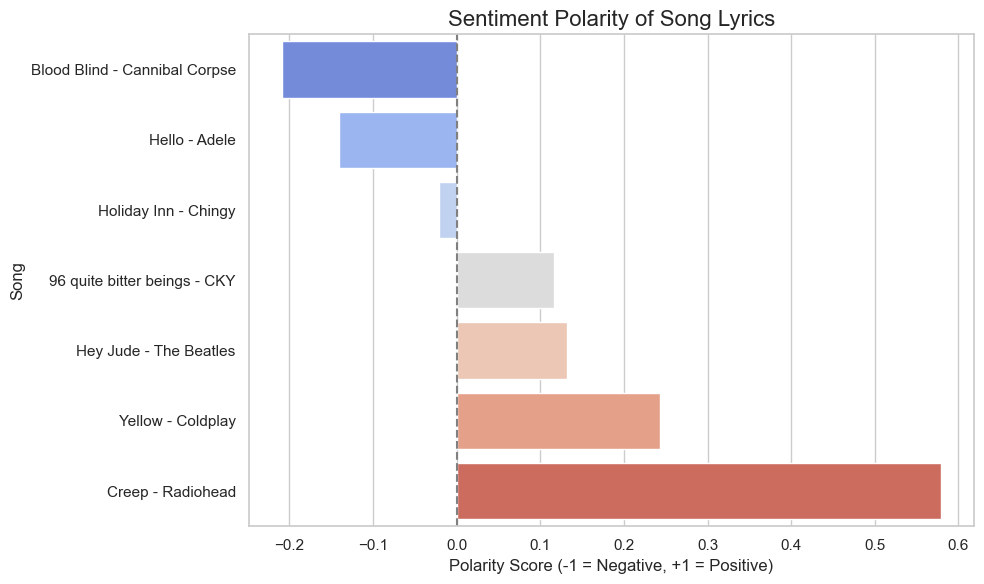

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Polarity data
polarity_scores = {title: get_lyrics_polarity(file) for title, file in songs.items()}

# Sort by polarity value
sorted_scores = dict(sorted(polarity_scores.items(), key=lambda item: item[1]))

# Visualization
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create horizontal barplot
sns.barplot(
    x=list(sorted_scores.values()),
    y=list(sorted_scores.keys()),
    hue=None,
    palette="coolwarm",
    orient='h',
    dodge=False
)

# Plot Labels
plt.title("Sentiment Polarity of Song Lyrics", fontsize=16)
plt.xlabel("Polarity Score (-1 = Negative, +1 = Positive)", fontsize=12)
plt.ylabel("Song", fontsize=12)
plt.axvline(0, color='gray', linestyle='--')  # Neutral line

# Print Plot
plt.tight_layout()
plt.show()


6. Export to HTML

In [51]:
import os 
os.system('jupyter nbconvert --to html requests-json-nlp.ipynb')

0